# DefDAP Example notebook

This notebook will outline basic usage of DefDAP, including loading a DIC and EBSD map, linking them with homologous points and producing maps

## Load in packages

DefDAP is split into modules for processing EBSD (`defdap.ebsd`) and HRDIC (`defdap.hrdic`) data. There are also modules for manpulating orientations (`defdap.quat`) and creating custom figures (`defdap.plotting`) which is introduced later. We also import some of the usual suspects of the python scientific stack: `numpy` and `matplotlib`.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import defdap.hrdic as hrdic
import defdap.ebsd as ebsd
from defdap.quat import Quat

# try tk, qt, osx (if using mac) or notebook for interactive plots. If none work, use inline
%matplotlib widget

## Load in a HRDIC map

In [2]:
dic_filepath = "tests/data/"
dic_map = hrdic.Map(dic_filepath, "testDataDIC.txt")

Loaded DaVis 8.4.0 data (dimensions: 300 x 200 pixels, sub-window size: 12 x 12 pixels)


### Set the scale of the map
This is defined as the pixel size in the DIC pattern images, measured in microns per pixel.

In [3]:
field_width = 20 # microns
num_pixels = 2048
dic_map.set_scale(field_width / num_pixels)

### Plot the map with a scale bar

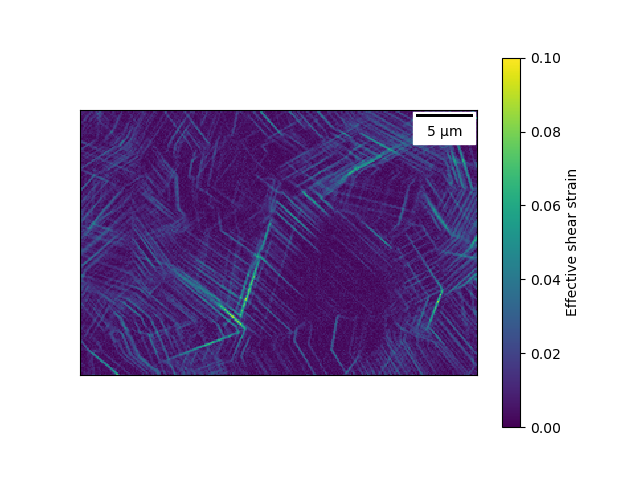

In [4]:
dic_map.plot_map('max_shear', vmin=0, vmax=0.10, plotScaleBar=True)

### Crop the map
HRDIC maps often contain spurious data at the edges which should be removed before performing any analysis. The crop is defined by the number of points to remove from each edge of the map, where `xMin`, `xMax`, `yMin` and `yMax` are the left, right, top and bottom edges respectively. Note that the test data doesn not require cropping as it is a subset of a larger dataset.

In [5]:
dic_map.set_crop(left=0, right=0, top=0, bottom=0)

### Statistics
Some simple statistics such as the minimum, mean and maximum of the effective shear strain, E11 and E22 components can be printed.

In [6]:
dic_map.printStatsTable(percentiles=[0, 50, 100], components = ['max_shear', 'e'])

dic_map (dimensions: 300 x 200 pixels, sub-window size: 12 x 12 pixels, number of points: 60000)

Component             0          50         100
max_shear        0.0000      0.0085      0.0910
e11             -0.1083     -0.0097      0.0168
e12             -0.0478      0.0005      0.0630
e21             -0.0478      0.0005      0.0630
e22             -0.0493      0.0045      0.0850


### Set the location of the DIC pattern images  
The pattern images are used later to define the position of homologous material points. The path is relative to the directory set when loading in the map. The second parameter is the pixel binning factor of the image relative to the DIC sub-region size i.e. the number of pixels in the image across a single datapoint in the DIC map. We recommend binning the pattern images by the same factor as the DIC sub-region size, doing so enhances the contrast between microstructure features.

In [7]:
# set the path of the pattern image, this is relative to the location of the DIC data file
dic_map.set_pattern("testDataPat.bmp", 1)

## Load in an EBSD map
Currently, OxfordBinary (a .crc and .cpr file pair), OxfordText (.ctf file), EdaxAng (.ang file) or PythonDict (Python dictionary) filetypes are supported. The crystal structure and slip systems are automatically loaded for each phase in the map. The orientation in the EBSD are converted to a quaternion representation so calculations can be applied later.

In [8]:
ebsd_map = ebsd.Map("tests/data/testDataEBSD", dataType = 'OxfordBinary')

Loaded EBSD data (dimensions: 359 x 243 pixels, step size: 0.12 um)


A list of detected phases and crystal structures can be printed

In [9]:
for i, phase in enumerate(ebsd_map.phases):
    print(i+1)
    print(phase)

1
Phase: Ni-superalloy
  Crystal structure: cubic
  Lattice params: (3.57, 3.57, 3.57, 90, 90, 90)
  Slip systems: cubic_fcc


A list of the slip planes, colours and slip directions can be printed

In [10]:
ebsd_map.phases[0].printSlipSystems()

Plane 0: (111)	Colour: blue
  Direction 0: [011̅]
  Direction 1: [1̅01]
  Direction 2: [11̅0]
Plane 1: (111̅)	Colour: green
  Direction 0: [011]
  Direction 1: [1̅01̅]
  Direction 2: [11̅0]
Plane 2: (1̅11)	Colour: red
  Direction 0: [011̅]
  Direction 1: [101]
  Direction 2: [1̅1̅0]
Plane 3: (11̅1)	Colour: white
  Direction 0: [01̅1̅]
  Direction 1: [1̅01]
  Direction 2: [110]


### Plot the EBSD map
Using an Euler colour mapping or inverse pole figure colouring with the sample reference direction passed as a vector.

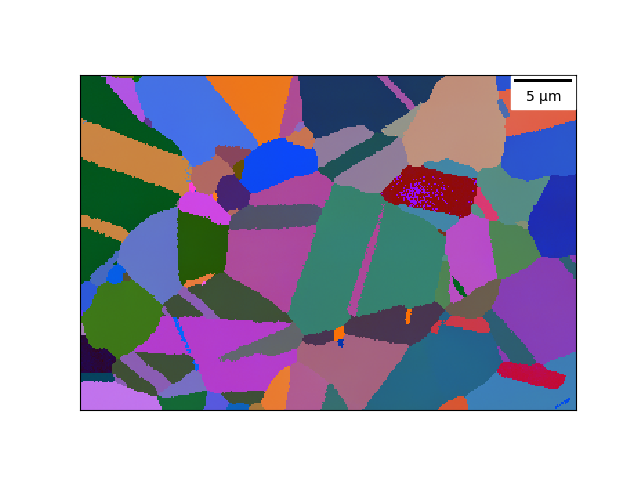

In [11]:
ebsd_map.plot_map('euler_angle', 'all_euler', plotScaleBar=True)

Finished building quaternion array (0:00:00) 


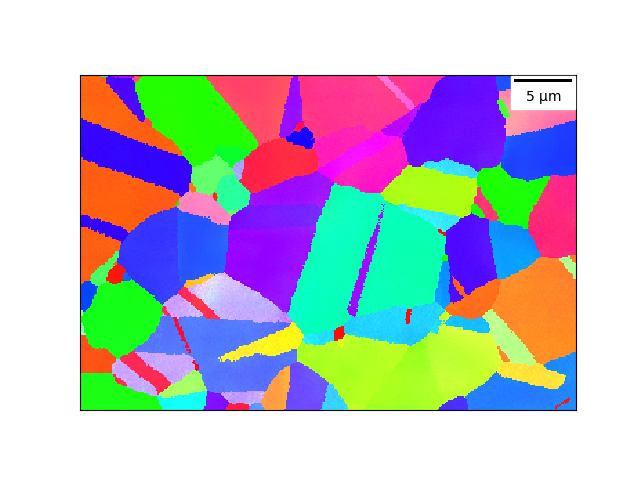

In [12]:
ebsd_map.plot_map('orientation', 'IPF_x', plotScaleBar=True)

A KAM map can also be plotted as follows

Finished calculating KAM (0:00:00) 


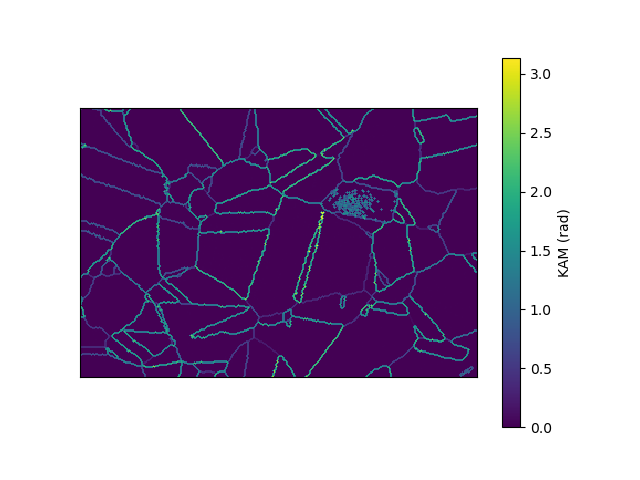

In [13]:
ebsd_map.plot_map('KAM')

### Detect grains in the EBSD
This is done in two stages: first bounaries are detected in the map as any point with a misorientation to a neighbouring point greater than a critical value (`boundDef` in degrees). A flood fill type algorithm is then applied to segment the map into grains, with any grains containining fewer than a critical number of pixels removed (`minGrainSize` in pixels). The data e.g. orientations associated with each grain are then stored (referenced strictly, the data isn't stored twice) in a grain object and a list of the grains is stored in the EBSD map (named `grainList`). This allows analysis routines to be applied to each grain in a map in turn.

In [14]:
ebsd_map.data.generate('grain_boundaries', misori_tol=8)
ebsd_map.data.generate('grains', min_grain_size=10)

Finished finding grain boundaries (0:00:00) 
Finished finding grains (0:00:00) 


The Schmid factors for each grain can be calculated and plotted. The `slipSystems` argument can be specified, to only calculate the Schmid factor for certain planes, otherwise the maximum for all slip systems is calculated.

In [15]:
ebsd_map.calcAverageGrainSchmidFactors(loadVector=np.array([1,0,0]), slipSystems=None)

Finished calculating grain average Schmid factors (0:00:00) 


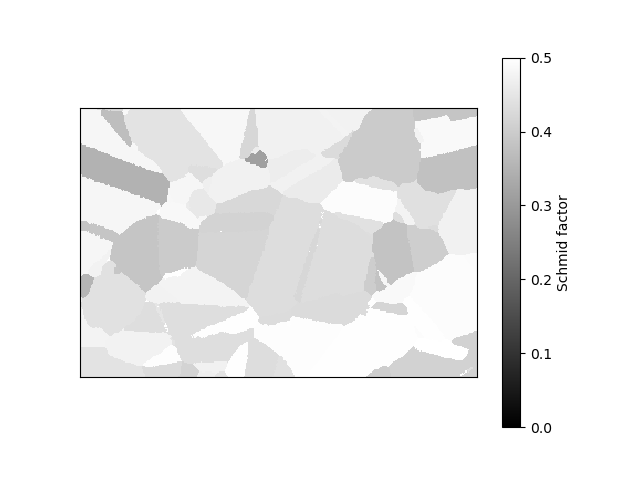

In [16]:
ebsd_map.plotAverageGrainSchmidFactorsMap()

### Single grain analysis
The `locateGrainID` method allows interactive selection of a grain of intereset to apply any analysis to. Clicking on grains in the map will highlight the grain and print out the grain ID (position in the grain list) of the grain.

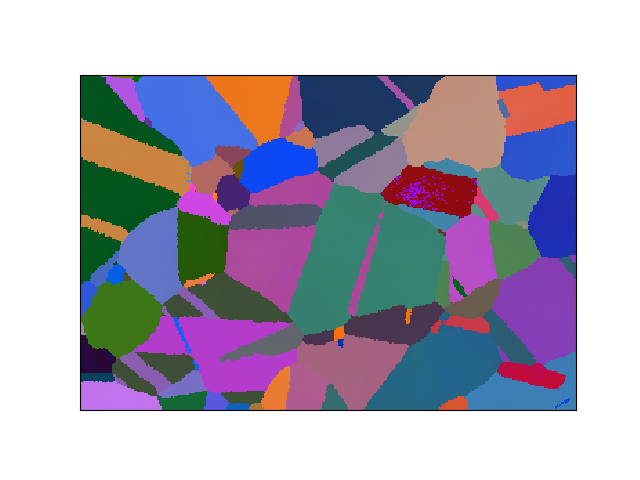

In [20]:
ebsd_map.locateGrainID()

In [21]:
ebsd_map.currGrainId

A built-in example is to calculate the average orientation of the grain and plot this orientation in a IPF

In [ ]:
grainID = 48
grain = ebsdMap[grainID]
grain.calcAverageOri()  # stored as a quaternion named grain.refOri
print(grain.refOri)
grain.plotRefOri(direction=[0, 0, 1])

The spread of orientations in a given grain can also be plotted on an IPF

In [ ]:
plot = grain.plotOriSpread(direction=np.array([0, 0, 1]), c='b', s=1, alpha=0.2)
grain.plotRefOri(direction=[0, 0, 1], c='k', plot=plot)

The unit cell for the average grain orientation can also be ploted

In [ ]:
grain.plotUnitCell()

Printing a list of the slip plane indices, angle of slip plane intersection with the screen (defined as counter-clockwise from upwards), colour defined for the slip plane and also the slip directions and corresponding Schmid factors, is also built in

In [ ]:
grain.printSlipTraces()

A second built-in example is to calcuate the grain misorientation, specifically the grain reference orientation deviation (GROD). This shows another feature of the `locateGrainID` method, which stores the ID of the last selected grain in a variable called `currGrainId` in the EBSD map.

In [ ]:
grain = ebsdMap[ebsdMap.currGrainId]
grain.buildMisOriList()
grain.plotMisOri(plotScaleBar=True, vmin=0, vmax=5)

### Multi grain analysis
Once an analysis routine has been prototyped for a single grain it can be applied to all the grains in a map using a loop over the grains and any results added to a list for use later. Of couse you could also apply to a smaller subset of grains as well.

In [ ]:
grainAvOris = []
for grain in ebsdMap:
    grain.calcAverageOri()
    grainAvOris.append(grain.refOri)

# Plot all the grain orientations in the map
Quat.plotIPF(grainAvOris, [0, 0, 1], ebsdMap.crystalSym, marker='o', s=10)
plt.tight_layout()

Some common grain analysis routines are built into the EBSD map object, including:

In [ ]:
ebsdMap.calcGrainAvOris()

In [ ]:
ebsdMap.calcGrainMisOri()
ebsdMap.plotMisOriMap(vmin=0, vmax=5, plotGBs=True, plotScaleBar=True)

There are also methods for plotting GND density, phases and boundaries. All of the plotting functions in DefDAP use the same parameters to modify the plot, examples seen so far are `plotGBs`, `plotScaleBar`, `vmin`, `vmax`.

## Linking the HRDIC and EBSD
### Define homologous points
To register the two datasets, homologous points (points at the same material location) within each map are used to estimate a transformation between the two frames the data are defined in. The homologous points are selected manually using an interactive tool within DefDAP. To select homologous call the method `setHomogPoint` on each of the data maps, which will open a plot window with a button labelled 'save point' in the bottom right. You select a point by right clicking on the map, adjust the position with the arrow  and accept the point by with the save point button. Then select the same location in the other map. Note that as we set the location of the pattern image for the HRDIC map that the points can be selected on the pattern image rather than the strain data.

In [ ]:
dicMap.setHomogPoint(map_name="pattern")

In [ ]:
ebsdMap.setHomogPoint()

The points are stored as a list of tuples `(x, y)` in each of the maps. This means the points can be set from previous values.

In [ ]:
dicMap.homogPoints

In [ ]:
ebsdMap.homogPoints

Here are some example homologous points for this data, after setting these by running the cells below you can view the locations in the maps by running the `setHomogPoint` methods (above) again

In [ ]:
dicMap.homogPoints = [
    (36, 72), 
    (279, 27), 
    (162, 174), 
    (60, 157)
]

In [ ]:
ebsdMap.homogPoints = [
    (68, 95), 
    (308, 45), 
    (191, 187), 
    (89, 174)
]

### Link the maps
Finally the two data maps are linked. The type of transform between the two frames can be affine, projective, polynomial.

In [ ]:
dicMap.linkEbsdMap(ebsdMap, transformType="affine")
# dicMap.linkEbsdMap(ebsdMap, transformType="projective")
# dicMap.linkEbsdMap(ebsdMap, transformType="polynomial", order=2)

### Show the transformation

In [ ]:
from skimage import transform as tf

data = np.zeros((2000, 2000), dtype=float)
data[500:1500, 500:1500] = 1.
dataWarped = tf.warp(data, dicMap.ebsdTransform)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(8,4))
ax1.set_title('Reference')
ax1.imshow(data)
ax2.set_title('Transformed')
ax2.imshow(dataWarped)

### Segment into grains
The HRDIC map can now be segmented into grains using the grain boundaries detected in the EBSD map. Analysis rountines can then be applied to individual grain, as with the EBSD grains. The grain finding process will also attempt to link the grains between the EBSD and HRDIC and each grain in the HRDIC has a reference (`ebsdGrain`) to the corrosponding grain in the EBSD map.

In [ ]:
dicMap.findGrains(minGrainSize=10)

In [ ]:
dicMap.plotMaxShear(vmin=0, vmax=0.1, plotScaleBar=True, plotGBs='line')

Now, a grain can also be selected interactively in the DIC map, in the same way a grain can be selected from an EBSD map. If `displaySelected` is set to true, then a pop-out window shows the map segmented for the grain

In [ ]:
dicMap.locateGrainID(displaySelected=True)

## Plotting examples

Some of the plotting features are shown in examples below.

### Built-in plots

In [ ]:
plot = dicMap.plotMaxShear(
    vmin=0, vmax=0.1, plotScaleBar=True,
    plotGBs=True, dilateBoundaries=True
)

In [ ]:
plot = ebsdMap.plotEulerMap(
    plotScaleBar=True, plotGBs=True,
    highlightGrains=[10, 20, 45], highlightAlpha=0.9, highlightColours=['y']
)

In [ ]:
dicGrainID = 41
dicGrain = dicMap[dicGrainID]

plot = dicGrain.plotMaxShear(
    plotScaleBar=True, plotSlipTraces=True, plotSlipBands=True
)

### IPF plotting

This plot will show the positions of selected grains in an IPF pole figure, with the marker size representing grain area and mean effective shear strain.

In [ ]:
# For all grains in the DIC map

# Make an array of quaternions
grainOris = [grain.ebsdGrain.refOri for grain in dicMap]

# Make an array of grain area
grainAreas = np.array([len(grain) for grain in dicMap]) * dicMap.scale**2

# Scaling the grain area, so that the maximum size of a marker is 200 points^2
grainAreaScaling = 200. / grainAreas.max()

# Make an array of mean effective shear strain
grainStrains = [np.array(grain.maxShearList).mean() for grain in dicMap]

plot = Quat.plotIPF(grainOris, direction=[1,0,0], symGroup='cubic', marker='o', 
                    s=grainAreas*grainAreaScaling, vmin=0, vmax=0.018, cmap='viridis', c=grainStrains)
plot.addColourBar(label='Mean Effective Shear Strain')
plot.addLegend(scaling=grainAreaScaling)

In [ ]:
# For selected grains in the DIC map

# Select grains from the DIC map
dicGrainIDs = [2, 5, 7, 9, 15, 17, 18, 23, 29, 32, 33, 37, 40, 42, 49, 50, 51, 54, 58, 60]

# Make an array of quaternions
grainOris = np.array([dicMap[grainID].ebsdGrain.refOri for grainID in dicGrainIDs])

# Make an array of grain area
grainAreas = np.array([len(dicMap[grainID]) for grainID in dicGrainIDs]) * dicMap.scale**2

# Scaling the grain area, so that the maximum size of a marker is 200 points^2
grainAreaScaling = 200. / grainAreas.max()

# Make an array of mean effective shear strain
grainStrains = np.array([np.mean(dicMap[grain].maxShearList) for grain in dicGrainIDs])

plot = Quat.plotIPF(grainOris, direction=[1,0,0], symGroup='cubic', marker='o', 
                    s=grainAreas*grainAreaScaling, vmin=0, vmax=0.018, cmap='viridis', c=grainStrains)
plot.addColourBar(label='Mean Effective Shear Strain')
plot.addLegend(scaling=grainAreaScaling)

### Create your own

In [ ]:
from defdap.plotting import MapPlot, GrainPlot, HistPlot

In [ ]:
mapData = dicMap.data['e'][0,0]
mapData = dicMap.crop(mapData)

plot = MapPlot.create(
    dicMap, mapData,
    vmin=-0.1, vmax=0.1, plotColourBar=True, cmap="seismic",
    plotGBs=True, dilateBoundaries=True, boundaryColour='black'
)

In [ ]:
plot.addScaleBar()

### Functions for grain averaging and grain segmentation

In [ ]:
plot = dicMap.plotGrainDataMap(
    mapData,
    vmin=-0.06, vmax=0.06, plotColourBar=True,
    cmap="seismic", clabel="Axial strain ($e_11$)",
    plotScaleBar=True
)


In [ ]:
plot.addGrainBoundaries(dilate=True, colour="white")

In [ ]:
plot = dicMap.plotGrainDataIPF(
    np.array((1,0,0)), mapData, marker='o',
    vmin=-0.06, vmax=0.06, plotColourBar=True, 
    clabel="Axial strain ($e_11$)", cmap="seismic",
)


In [ ]:
dicGrainID = 41
dicGrain = dicMap[dicGrainID]

plot = dicGrain.plotGrainData(
    mapData, 
    vmin=-0.1, vmax=0.1, plotColourBar=True, 
    clabel="Axial strain ($e_11$)", cmap="seismic",
    plotScaleBar=True
)


In [ ]:
plot.addSlipTraces()

### Composite plots

By utilising some additional functionality within matplotlib, composite plots can be produced.

In [ ]:
from matplotlib import gridspec

In [ ]:
# Create a figure with 3 sets of axes
fig = plt.figure(figsize=(8, 4))
gs = gridspec.GridSpec(2, 2, width_ratios=[3, 1],
                       wspace=0.15, hspace=0.15, 
                       left=0.02, right=0.98,
                       bottom=0.12, top=0.95) 
ax0 = plt.subplot(gs[:, 0])
ax1 = plt.subplot(gs[0, 1])
ax2 = plt.subplot(gs[1, 1])


# add a strain map
plot0 = dicMap.plotMaxShear(
    ax=ax0, fig=fig, 
    vmin=0, vmax=0.08, plotScaleBar=True, 
    plotGBs=True, dilateBoundaries=True
)

# add an IPF of grain orientations
dicOris = []
for grain in dicMap:
    if len(grain) > 20:
        dicOris.append(grain.refOri)
plot1 = Quat.plotIPF(
    dicOris, np.array((1,0,0)), 'cubic', 
    ax=ax1, fig=fig, s=10
)

# add histrogram of strain values
plot2 = HistPlot.create(
    dicMap.crop(dicMap.data.max_shear),
    ax=ax2, fig=fig, marker='o', markersize=2,
    axesType="logy", bins=50, range=(0,0.06)
)
plot2.ax.set_xlabel("Effective shear strain")

Figures can be saved to raster (png, jpg, ..) and vector formats (eps, svg), the format is guessed from the file extension given. The last displayed figure can be saved using:

In [ ]:
#plt.savefig("test_save_fig.png", dpi=200)
#plt.savefig("test_save_fig.eps", dpi=200)

In [ ]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2, 2, figsize=(8, 6))

dicGrainID = 41
dicGrain = dicMap[dicGrainID]

# add a strain map
plot0 = dicGrain.plotMaxShear(
    ax=ax0, fig=fig, 
    vmin=0, vmax=0.08, plotScaleBar=True,
    plotSlipTraces=True
)


# add a misorientation
ebsdGrain = dicGrain.ebsdGrain
plot1 = ebsdGrain.plotMisOri(component=0, ax=ax1, fig=fig, vmin=0, vmax=1, clabel="GROD", plotScaleBar=True)


# add an IPF
plot2 = ebsdGrain.plotOriSpread(
    direction=np.array((1,0,0)), c='b', s=1, alpha=0.2,
    ax=ax2, fig=fig
)
ebsdGrain.plotRefOri(
    direction=np.array((1,0,0)), c='k', s=100, plot=plot2
)

# add histrogram of strain values
plot3 = HistPlot.create(
    dicMap.crop(dicMap.data.max_shear),
    ax=ax3, fig=fig,
    axesType="logy", bins=50, range=(0,0.06))
    
plot3.ax.set_xlabel("Effective shear strain")


plt.tight_layout()

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

import defdap.hrdic as hrdic
import defdap.ebsd as ebsd
from defdap.quat import Quat
from defdap.experiment import Experiment

In [ ]:
dic_path = "tests/data/"
dic_map = hrdic.Map(dic_path, "testDataDIC.txt")

ebsd_path = "tests/data/testDataEBSD"
ebsd_map = ebsd.Map(ebsd_path, dataType = 'OxfordBinary')

In [ ]:
my_experiment = Experiment()
inc = my_experiment.add_increment(order=1)

inc.add_map('dic', dic_map)
inc.add_map('ebsd', ebsd_map)
